<a href="https://colab.research.google.com/github/ElizabethGarrison/Working-With-Data-Fundamentals/blob/main/ResearchingTwitter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Researching Twitter
## Part I. Scraping text

We'll look at social media like twitter as a source of data, and review some kinds of content coding. (If there is interest, we can look again at machine learning.)

We'll use as an example part of a research project that I am working on to investigate identity construction for American evangelicals.

I'm splitting the work into two notebooks for simplicity. The first, this one, will demonstrate the steps for data collecting: searching for tweets by content keywords and writing the results to an Excel file.

In the second notebook, I'll import the Excel files and combine them in a DataFrame and perform the content analysis.

In [ ]:
# Code block 1: installations
!pip install git+https://github.com/tweepy/tweepy.git
!pip install pyreadstat
!pip install researchpy
!pip install openpyxl --upgrade
!pip install contractions

In [ ]:
# Code block 2a: Import libraries
import tweepy as twp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
import json
import math
import collections as cl
import matplotlib.pyplot as plt
import researchpy as rp
import re
import contractions
import string
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


In [ ]:
# Code block 2b: Import NLTK
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn

wnl = nltk.WordNetLemmatizer()
wnp = nltk.PorterStemmer()
en_stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

Here's the tweepy documentation:
https://docs.tweepy.org/en/stable/index.html

In [ ]:
# Twitter authentication information -- I'll share this when we meet on Zoom.
BEARER_TOKEN='AAAAAAAAAAAAAAAAAAAAAHFMWQEAAAAAHCUFPlZyghaEf8Mrf6nzkMPGpVQ%3DFxlYaFZtq3o8MOWY0Jdm3zoqv5jY3rG8r90I6FL0uA9c1iLq68'
CONSUMER_KEY='P99VOkEnrhWM5Axv3ad4rw6Or'
CONSUMER_SECRET='1DKhTOOou1FNRZVM3e07AGJyAGQSy5KxaI3kUbCPuUkxuc0ARm'
OAUTH_TOKEN='62099456-pjU1wN5RSwE3xsPuupvAc1idlt0QYhF9DhGgInMDq'
OAUTH_TOKEN_SECRET='48RP6BhNIeK0zdiLSKY8HGHKKyIlpiiLN5fZHrs5HU7sK'

In [ ]:
client = twp.Client(bearer_token=BEARER_TOKEN,
                    consumer_key=CONSUMER_KEY,
                    consumer_secret=CONSUMER_SECRET,
                    access_token=OAUTH_TOKEN,
                    access_token_secret=OAUTH_TOKEN_SECRET,
                    wait_on_rate_limit=True
                    )

newclient = twp.Client(bearer_token=BEARER_TOKEN)

In [ ]:
search_df = pd.DataFrame()
timeline_df = pd.DataFrame()

start_time = '2022-09-01T00:00:00Z'
end_time = '2022-11-15T00:00:00Z'

a0 = 'free speech place_country:US'

for tweet in twp.Paginator(client.search_all_tweets,
        query=a0, expansions='author_id', start_time=start_time,
        end_time=end_time, max_results=500
        ).flatten(100):

        searchseries = pd.Series([tweet.text, str(tweet.id), str(tweet.author_id)], index=['status', 'tweetid', 'userid'])
        search_df = search_df.append(searchseries, ignore_index=True)

search_df

,status,tweetid,userid
0,@elonmusk @AfricanNri @langdon @EricFrohnhoefe...,1592304400336556032,1305282123834642432
1,@Strandjunker The first Amendment only applies...,1592299678129061888,265688982
2,Free speech ain’t free,1592291481624403968,711661593755389952
3,Free speech still has consequences…,1592289264229748736,58368350
4,"FOLKS, JASON MILLER IS\nCEO OF FREE SPEECH\nSO...",1592280821926432768,1561543978767491072
...,...,...,...
95,@elonmusk I came back b/c of u. Thank u for tr...,1591960838176641024,1518665702764429313
96,@elonmusk @_hawko Think I’ll believe Elon rath...,1591953295144554496,835997583977803777
97,"@AnnOkla Yeah, and Elon punished me by deletin...",1591951258608631808,3676507156
98,"@Phylter52 WTAH??? Sorry, Tennessee Legislatur...",1591943985270239234,329802061


In [ ]:
search_df['searchterm'] = 'free speech'
search_df['country'] = 'US'

In [ ]:
twitterdiscourse_df = search_df

In case we run into a problem with the client rate limit, I shared a copy of this spreadsheet from a broader search for 'free speech' in recent tweets.

In [ ]:
twitterdiscourse_df = pd.read_excel('/content/drive/MyDrive/Data/twitterDiscourseFreeSpeechNovember2022.xlsx', na_values=['NA'])

You can see in the tweepy documentation what kind of information about users you can access. In this case, I'm creating a DataFrame from multiple user fields in order to do some modeling.

tweepy: https://docs.tweepy.org/en/latest/api.html#follow-search-and-get-users

It is also helpful to be familiar with the data dictionary: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview

You can consult the data dictionary on the Twitter API for information about what content is available.

https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

In [ ]:
def find_links(tweet):
    #function  extracts the links
    return re.findall('(http\S+|bit.ly/\S+)', tweet)

def find_hashtags(tweet):
    #This function will extract hashtags
    return re.findall('(#[A-Za-z0-9]+[A-Za-z0-9-_]+)', tweet)

twitterdiscourse_df['links'] = twitterdiscourse_df.status.apply(find_links)
twitterdiscourse_df['hashtags'] = twitterdiscourse_df.status.apply(find_hashtags)


In [ ]:
twitterdiscourse_df[['corpora']] = twitterdiscourse_df[['status']]
twitterdiscourse_df

,Unnamed: 0,status,tweetid,userid,handle,username,profile,followers,tweets,lists,searchterm,country,links,hashtags,corpora
0,0,Nice one! https://t.co/jyP2vmDEFp,1597673873671348224,1305282123834642432,TheLastUprising - Real Climate Action Now.,TheLastUprisin1,"This is the time where humanity rises up, or t...",2653,79494,21,free speech,US,[https://t.co/jyP2vmDEFp],[],Nice one! https://t.co/jyP2vmDEFp
1,1,RT @ElBartoArmy: https://t.co/kFghnyTS6c,1597669857860128768,1305282123834642432,TheLastUprising - Real Climate Action Now.,TheLastUprisin1,"This is the time where humanity rises up, or t...",2653,79494,21,free speech,US,[https://t.co/kFghnyTS6c],[],RT @ElBartoArmy: https://t.co/kFghnyTS6c
2,2,Please help if you can! ❤️❤️❤️❤️ https://t.co/...,1597669799999705088,1305282123834642432,TheLastUprising - Real Climate Action Now.,TheLastUprisin1,"This is the time where humanity rises up, or t...",2653,79494,21,free speech,US,[https://t.co/OUYH0S3irL],[],Please help if you can! ❤️❤️❤️❤️ https://t.co/...
3,3,#Gross https://t.co/FOEtM8yCPs,1597669396134375424,1305282123834642432,TheLastUprising - Real Climate Action Now.,TheLastUprisin1,"This is the time where humanity rises up, or t...",2653,79494,21,free speech,US,[https://t.co/FOEtM8yCPs],[#Gross],#Gross https://t.co/FOEtM8yCPs
4,4,https://t.co/LjCQeS8AjJ https://t.co/hEgHVnC6si,1597666921293697025,1305282123834642432,TheLastUprising - Real Climate Action Now.,TheLastUprisin1,"This is the time where humanity rises up, or t...",2653,79494,21,free speech,US,"[https://t.co/LjCQeS8AjJ, https://t.co/hEgHVnC...",[],https://t.co/LjCQeS8AjJ https://t.co/hEgHVnC6si
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63206,63206,@elonmusk I heard he said he wasn't coming bac...,1593720866260799488,35217224,Eddie Meyer,lonerlonely,"All you nations, praise the Lord.",217,5825,0,free speech,US,[],[],@elonmusk I heard he said he wasn't coming bac...
63207,63207,@nmcerulean @ofctimallen A ... No,1593668704755408896,35217224,Eddie Meyer,lonerlonely,"All you nations, praise the Lord.",217,5825,0,free speech,US,[],[],@nmcerulean @ofctimallen A ... No
63208,63208,@nmcerulean @ofctimallen Glad he is doing good...,1593668501000314880,35217224,Eddie Meyer,lonerlonely,"All you nations, praise the Lord.",217,5825,0,free speech,US,[],[],@nmcerulean @ofctimallen Glad he is doing good...
63209,63209,@GeraldoRivera The new Congress hasn't been sw...,1593381605325750272,35217224,Eddie Meyer,lonerlonely,"All you nations, praise the Lord.",217,5825,0,free speech,US,[],[],@GeraldoRivera The new Congress hasn't been sw...


In [ ]:
# These are the search keywords
topic_keywords = set(['racism', 'politics', 'election', 'trump', 'white', 'religion', 'faith',
                      'leader', 'black', 'conservative', 'liberal', 'progressive',
                      'voting', 'democracy', 'republican', 'democrat', 'independent',
                      'moderate', 'centrist', 'right', 'left', 'communism', 'socialism',
                      'feminism', 'freedom', 'libertarian'
                      ])
topic_labels = list(topic_keywords)

# Keyword coding manually identified terms
keywords2 = {}
keyword_counts2 = {}

def wn_keyword_count2(words):
    for term in topic_keywords:
        keyword_counts2[term] = 0

    for word in words:
        for term in topic_keywords:
            if word.find(term) != -1:
                keyword_counts2[term] += 1

    return keyword_counts2


In [ ]:
# This block does the content coding with the coding functions defined above.
content0_df = pd.DataFrame()

for tweet in twitterdiscourse_df.status:
    tweet_tokens = nltk.word_tokenize(tweet)
    tweet_tokens2 = [t.lower() for t in tweet_tokens]
    content_coding0 = pd.Series(wn_keyword_count2(tweet_tokens2), index=list(topic_labels))
    content0_df = content0_df.append(content_coding0, ignore_index=True)
twittercoded_df = content0_df
twittercoded_df

# There are two relevant dataframes: twitterdiscourse_df contains the text data
# and twittercoded_df contains the coding results.

,republican,politics,freedom,libertarian,racism,trump,democrat,centrist,communism,left,...,black,voting,moderate,religion,leader,independent,white,feminism,liberal,election
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
twittercoded_df['trump'].describe()

count    63211.000000
mean         0.017181
std          0.143924
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: trump, dtype: float64

In [ ]:
X = twittercoded_df[[
    'republican', 'democrat', 'liberal', 'conservative', 'left', 'right',
    'right', 'feminism', 'racism', 'election', 'white', 'black', 'freedom',
    'socialism'
]]
Y = twittercoded_df['trump']
X = sm.add_constant(X)
model0 = sm.OLS(Y, X, missing='drop').fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:                  trump   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     26.30
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           6.03e-65
Time:                        16:59:29   Log-Likelihood:                 33011.
No. Observations:               63211   AIC:                        -6.599e+04
Df Residuals:                   63197   BIC:                        -6.587e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0162      0.001     27.089   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
keyword_cofreq = twittercoded_df.T.dot(twittercoded_df)
keyword_dist = 64000 - keyword_cofreq
keyword_dist  # distance matrix

,republican,politics,freedom,libertarian,racism,trump,democrat,centrist,communism,left,...,black,voting,moderate,religion,leader,independent,white,feminism,liberal,election
republican,62833.0,64000.0,63980.0,64000.0,64000.0,63980.0,63624.0,64000.0,64000.0,63988.0,...,64000.0,63985.0,64000.0,64000.0,63966.0,64000.0,64000.0,64000.0,63980.0,64000.0
politics,64000.0,63831.0,64000.0,63984.0,64000.0,64000.0,64000.0,64000.0,64000.0,63994.0,...,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0
freedom,63980.0,64000.0,63411.0,64000.0,63961.0,64000.0,63932.0,64000.0,64000.0,63961.0,...,64000.0,64000.0,64000.0,63910.0,64000.0,64000.0,63883.0,64000.0,63903.0,64000.0
libertarian,64000.0,63984.0,64000.0,63951.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,...,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0
racism,64000.0,64000.0,63961.0,64000.0,63832.0,64000.0,63961.0,64000.0,64000.0,63961.0,...,63974.0,64000.0,64000.0,63976.0,64000.0,64000.0,63883.0,64000.0,63961.0,63976.0
trump,63980.0,64000.0,64000.0,64000.0,64000.0,62672.0,63966.0,64000.0,64000.0,64000.0,...,64000.0,64000.0,64000.0,64000.0,63960.0,64000.0,63962.0,64000.0,64000.0,64000.0
democrat,63624.0,64000.0,63932.0,64000.0,63961.0,63966.0,61905.0,64000.0,64000.0,63894.0,...,64000.0,63819.0,64000.0,64000.0,63919.0,63926.0,63608.0,64000.0,63856.0,63963.0
centrist,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,63949.0,64000.0,63942.0,...,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0
communism,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,63938.0,64000.0,...,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0,64000.0
left,63988.0,63994.0,63961.0,64000.0,63961.0,64000.0,63894.0,63942.0,64000.0,62552.0,...,64000.0,64000.0,64000.0,63958.0,64000.0,64000.0,63883.0,64000.0,63961.0,64000.0


In [ ]:
mds = MDS(metric=False, n_components = 2, random_state=0, dissimilarity='precomputed')
pca = PCA(n_components=2)
twitterthemes_transform = mds.fit_transform(keyword_dist)
print(twitterthemes_transform)
print(mds.stress_)

[[ 0.31241236  0.24013055]
 [-0.13309496 -0.39360883]
 [ 0.12141443  0.14843883]
 [ 0.12950396  0.40479229]
 [ 0.25876469  0.36482752]
 [-0.45630328 -0.04412133]
 [ 0.29579912 -0.29320459]
 [ 0.00659629 -0.47823304]
 [-0.29396493 -0.40910548]
 [ 0.42730205 -0.21231116]
 [-0.05800644  0.55018772]
 [ 0.23922763 -0.47088388]
 [-0.41784003  0.28351153]
 [ 0.15500112 -0.30524262]
 [ 0.49023351  0.30951947]
 [ 0.03178331  0.34185224]
 [ 0.32352943 -0.19375318]
 [-0.01641742 -0.21856259]
 [-0.40009383  0.66113263]
 [ 0.37294578  0.14495575]
 [-0.36959581 -0.20984062]
 [-0.64286054  0.06767303]
 [-0.27086622  0.4188917 ]
 [-0.12798055 -0.35394795]
 [-0.64528085 -0.4953919 ]
 [ 0.33613585  0.08389268]]
13.797092456327594


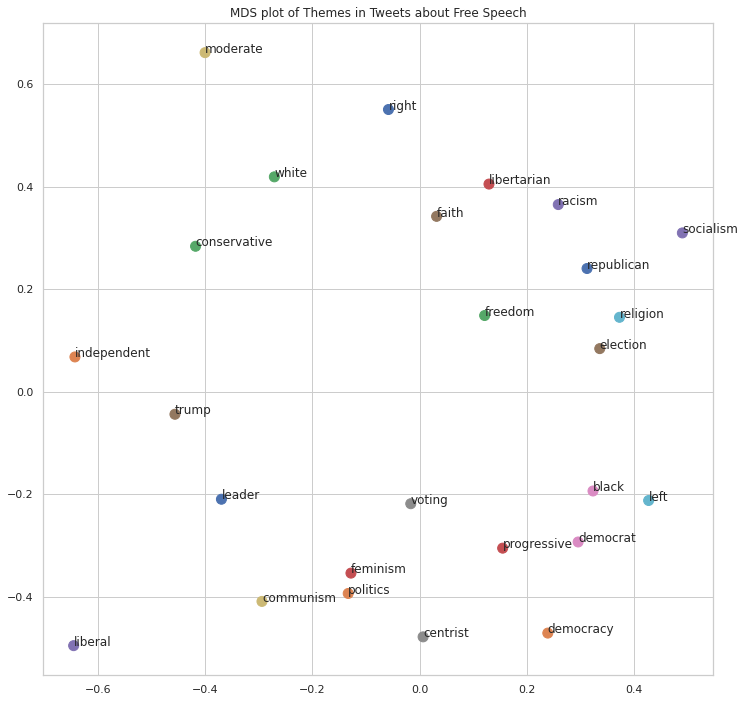

In [ ]:
sb.set_theme(style="whitegrid")
fig = plt.figure(figsize=(12,12))
i = 0
while i < len(twittercoded_df.columns):
    plt.scatter(twitterthemes_transform[i,0], twitterthemes_transform[i,1], sizes=(100, 100))
    plt.text(twitterthemes_transform[i,0], twitterthemes_transform[i,1], twittercoded_df.columns[i])
    i += 1
plt.title('MDS plot of Themes in Tweets about Free Speech')
plt.show()

## Activity

A. Select a search term and a timeframe and conduct a search for tweets.

B. Use the keyword coding function to code for some relevant themes.

C. Compute a model to explain some aspect of the relationship between themes.

D. Construct a graph depicting the relationship among themes.

In [ ]:
# Code block 1: installations
!pip install git+https://github.com/tweepy/tweepy.git
!pip install pyreadstat
!pip install researchpy
!pip install openpyxl --upgrade
!pip install contractions

  Cloning https://github.com/tweepy/tweepy.git to /tmp/pip-req-build-ii61_z12
  Running command git clone --filter=blob:none --quiet https://github.com/tweepy/tweepy.git /tmp/pip-req-build-ii61_z12
  Resolved https://github.com/tweepy/tweepy.git to commit f32d12dbddbd877470446657812a10a04292d0c9
  Preparing metadata (setup.py) ... done
  Created wheel for tweepy: filename=tweepy-4.14.0-py3-none-any.whl size=99197 sha256=2d034a06321af43d5394980073aff1a97ac54eaeca52aa79922ecae657cb3e4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-mh5bfxge/wheels/dc/75/73/ac2b7c1ac66d801a0b03c7707a2fc16e8689f792b585994c6f
Successfully built tweepy
  Attempting uninstall: tweepy
    Found existing installation: tweepy 4.13.0
    Uninstalling tweepy-4.13.0:
      Successfully uninstalled tweepy-4.13.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Code block 2a: Import libraries
import tweepy as twp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
import json
import math
import collections as cl
import matplotlib.pyplot as plt
import researchpy as rp
import re
import contractions
import string
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

In [ ]:
# Code block 2b: Import NLTK
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn

wnl = nltk.WordNetLemmatizer()
wnp = nltk.PorterStemmer()
en_stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [ ]:
# Twitter authentication information -- I'll share this when we meet on Zoom.
BEARER_TOKEN='AAAAAAAAAAAAAAAAAAAAAHFMWQEAAAAAHCUFPlZyghaEf8Mrf6nzkMPGpVQ%3DFxlYaFZtq3o8MOWY0Jdm3zoqv5jY3rG8r90I6FL0uA9c1iLq68'
CONSUMER_KEY='P99VOkEnrhWM5Axv3ad4rw6Or'
CONSUMER_SECRET='1DKhTOOou1FNRZVM3e07AGJyAGQSy5KxaI3kUbCPuUkxuc0ARm'
OAUTH_TOKEN='62099456-pjU1wN5RSwE3xsPuupvAc1idlt0QYhF9DhGgInMDq'
OAUTH_TOKEN_SECRET='48RP6BhNIeK0zdiLSKY8HGHKKyIlpiiLN5fZHrs5HU7sK'

In [ ]:
client = twp.Client(bearer_token=BEARER_TOKEN,
                    consumer_key=CONSUMER_KEY,
                    consumer_secret=CONSUMER_SECRET,
                    access_token=OAUTH_TOKEN,
                    access_token_secret=OAUTH_TOKEN_SECRET,
                    wait_on_rate_limit=True
                    )

newclient = twp.Client(bearer_token=BEARER_TOKEN)